In [7]:
import numpy as np
import matplotlib.pyplot as plt
# import mkl

# mkl.set_num_threads(2)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [8]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

# MNIST dataset

/tmp/ipykernel_4472/1763094123.py:5: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))


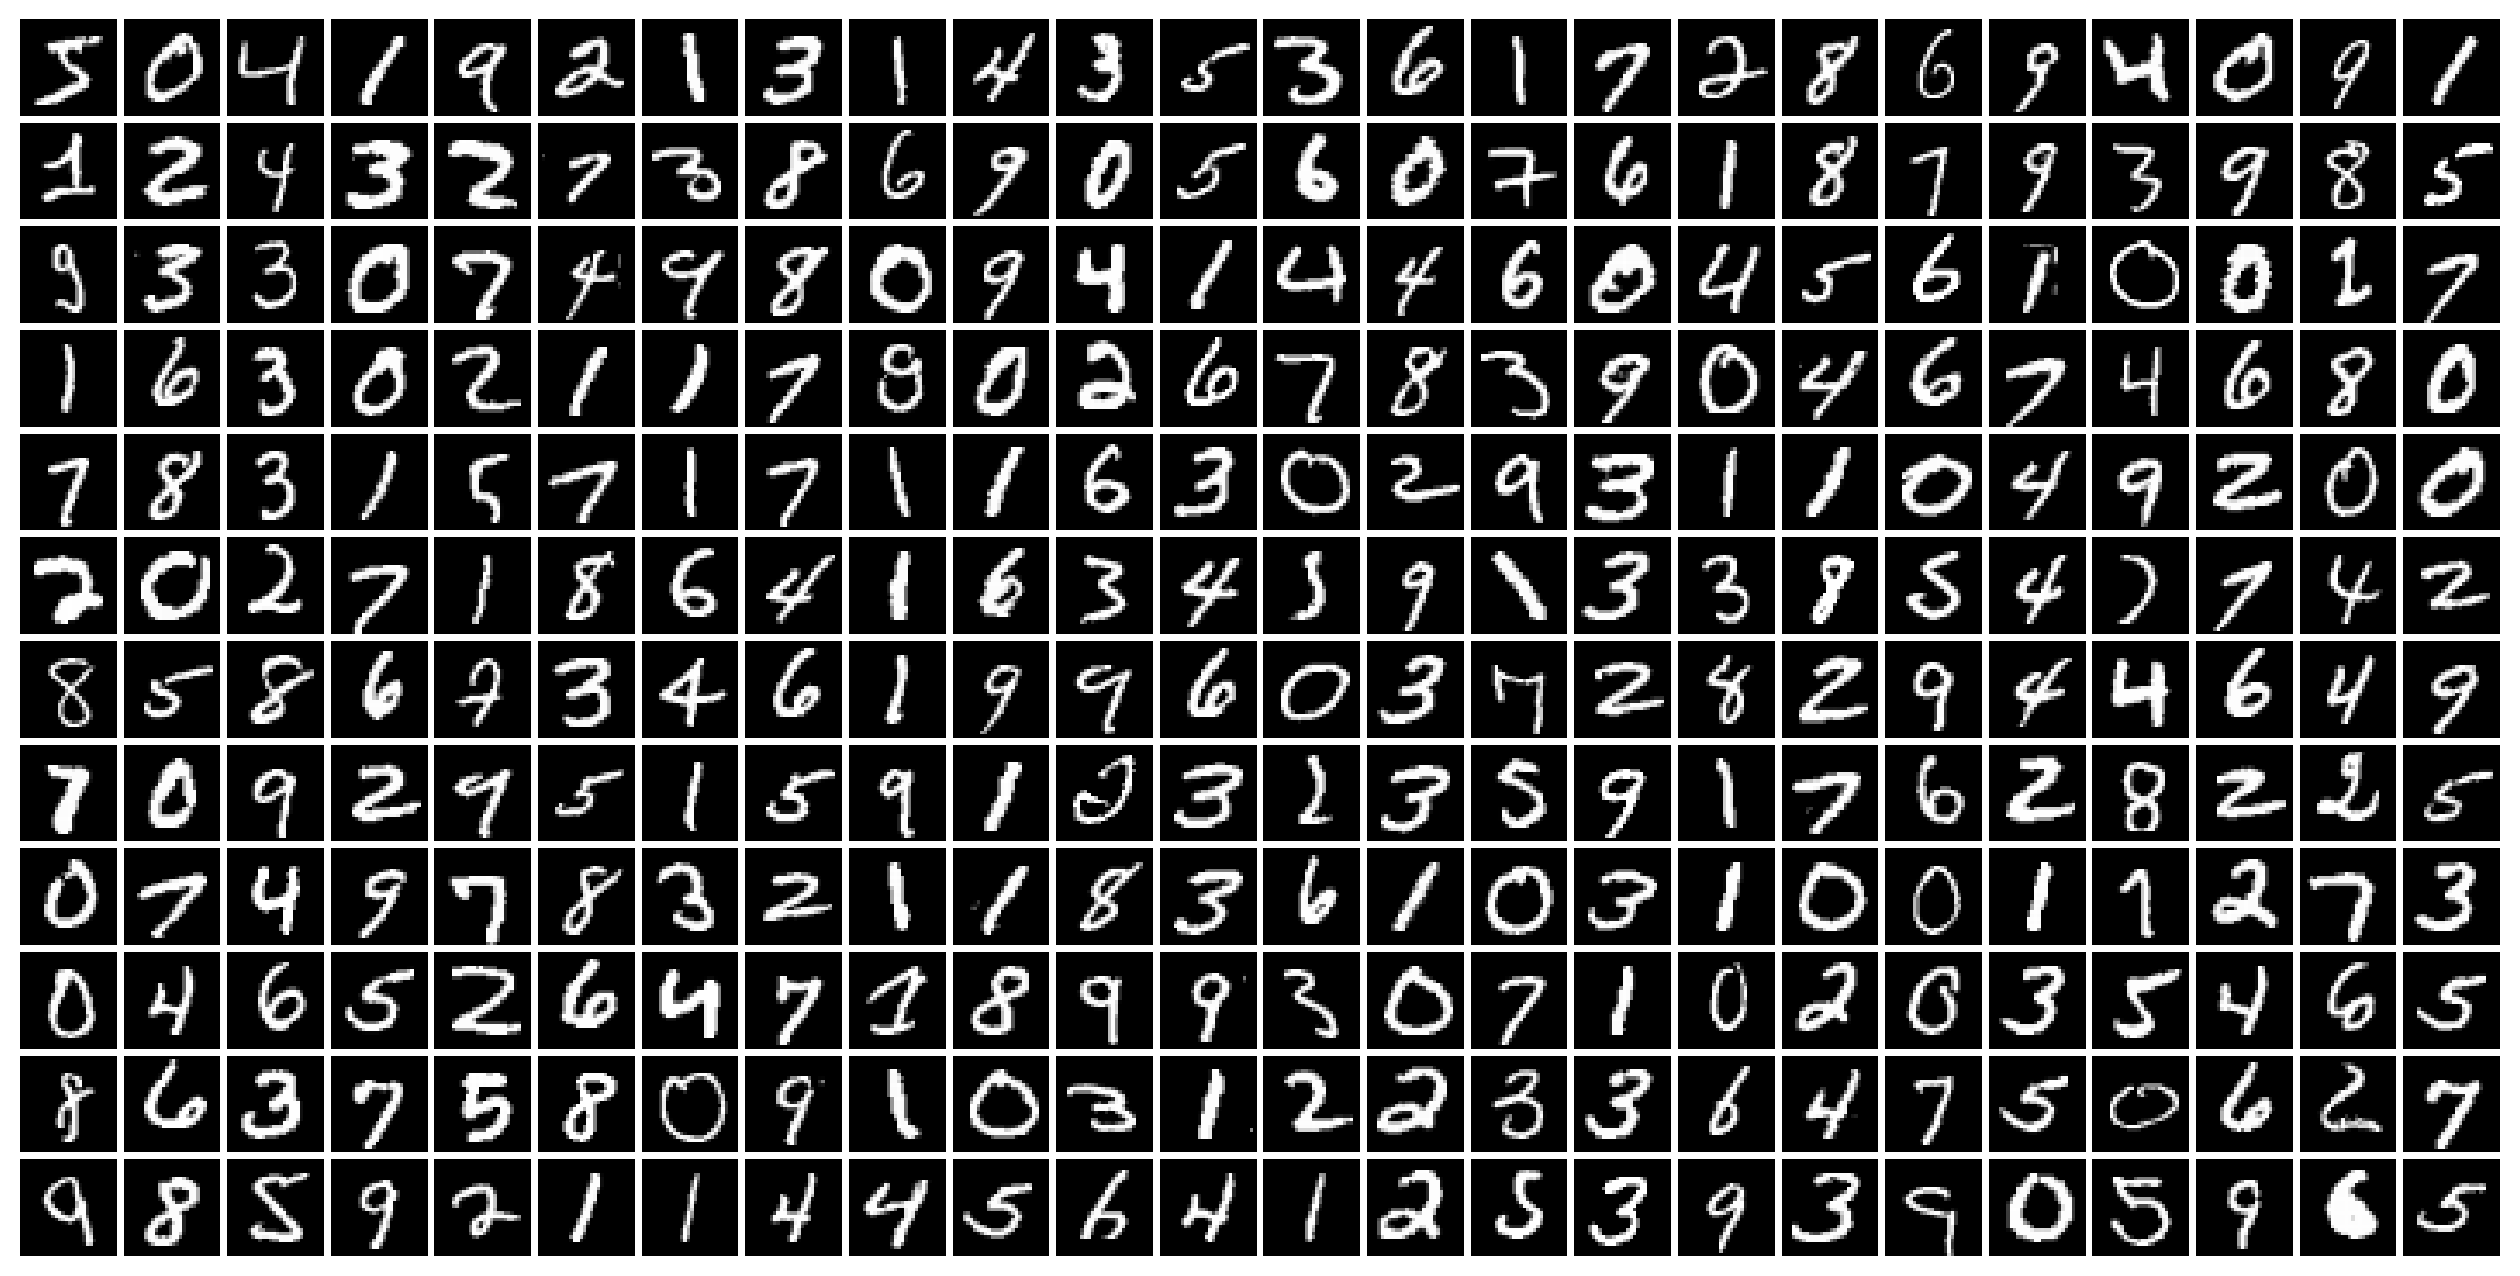

In [9]:
# import mnist
import mnists

mnist = mnists.MNIST()
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# Restricted Boltzmann Machine & Contrastive Divergence algorithm

In [10]:
def sigmoid(matrix):
    return 1.0 / (1.0 + np.exp(-matrix))

class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate, momentum):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size+1, self.hidden_size+1) 

In [12]:
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    hidden[:, :-1] = sigmoid(minibatch @ rbm.W[:, :-1]) > rand(*(minibatch @ rbm.W[:, :-1]).shape)
    visible = sigmoid(hidden @ rbm.W[:-1, :].T)

    error = np.sum((minibatch[:, :-1] - visible) ** 2) / minibatch.shape[0]

    return error

In [13]:
def train_epoch(rbm, dataset, batch_size):
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(rbm, batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

def run_training(rbm, dataset, monitoring_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch),  end="\t")
        
        if epoch == 5:
            rbm.momentum = 0.8

        start_time = time.time()
        train_epoch(rbm, dataset, batch_size)
        elapsed = time.time() - start_time
        
        error = reconstuction_error(rbm, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

    print("Training finished!")

In [14]:
def draw_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

# 1. RBM Training with momentum

In [24]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    # Positive
    positive_hidden[:, :-1] = sigmoid(positive_visible @ rbm.W[:, :-1])

    # Negative
    negative_hidden[:, :-1] = positive_hidden[:, :-1] > rand(*(positive_hidden[:, :-1]).shape)
    negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(*(negative_hidden @ rbm.W[:-1, :].T).shape)

    for step in range(k-1):
        negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1]) > rand(*(negative_visible @ rbm.W[:, :-1]).shape)
    
        negative_visible[:, :-1] = sigmoid(negative_hidden @ rbm.W[:-1, :].T) > rand(*(negative_hidden @ rbm.W[:-1, :].T).shape)

    negative_hidden[:, :-1] = sigmoid(negative_visible @ rbm.W[:, :-1])

    positive_grad = positive_visible.T @ positive_hidden
    negative_grad = negative_visible.T @ negative_hidden

    model_change = rbm.learning_rate * ((positive_grad - negative_grad) / observations_count)
    rbm.M = rbm.momentum * rbm.M + model_change

    rbm.W += rbm.M

In [25]:
import time

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 128

mnist_train = mnist.train_images().astype(np.float32) / 255.0
np.random.shuffle(mnist_train)
dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
dataset = append_ones(dataset)

monitoring_indeces = np.random.choice(DATASET_SIZE, 256, replace=False)
monitoring_set = dataset[monitoring_indeces]

/tmp/ipykernel_4472/3750985892.py:11: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  dataset = np.reshape(mnist_train[:DATASET_SIZE], newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))


/tmp/ipykernel_4472/3631771926.py:2: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))


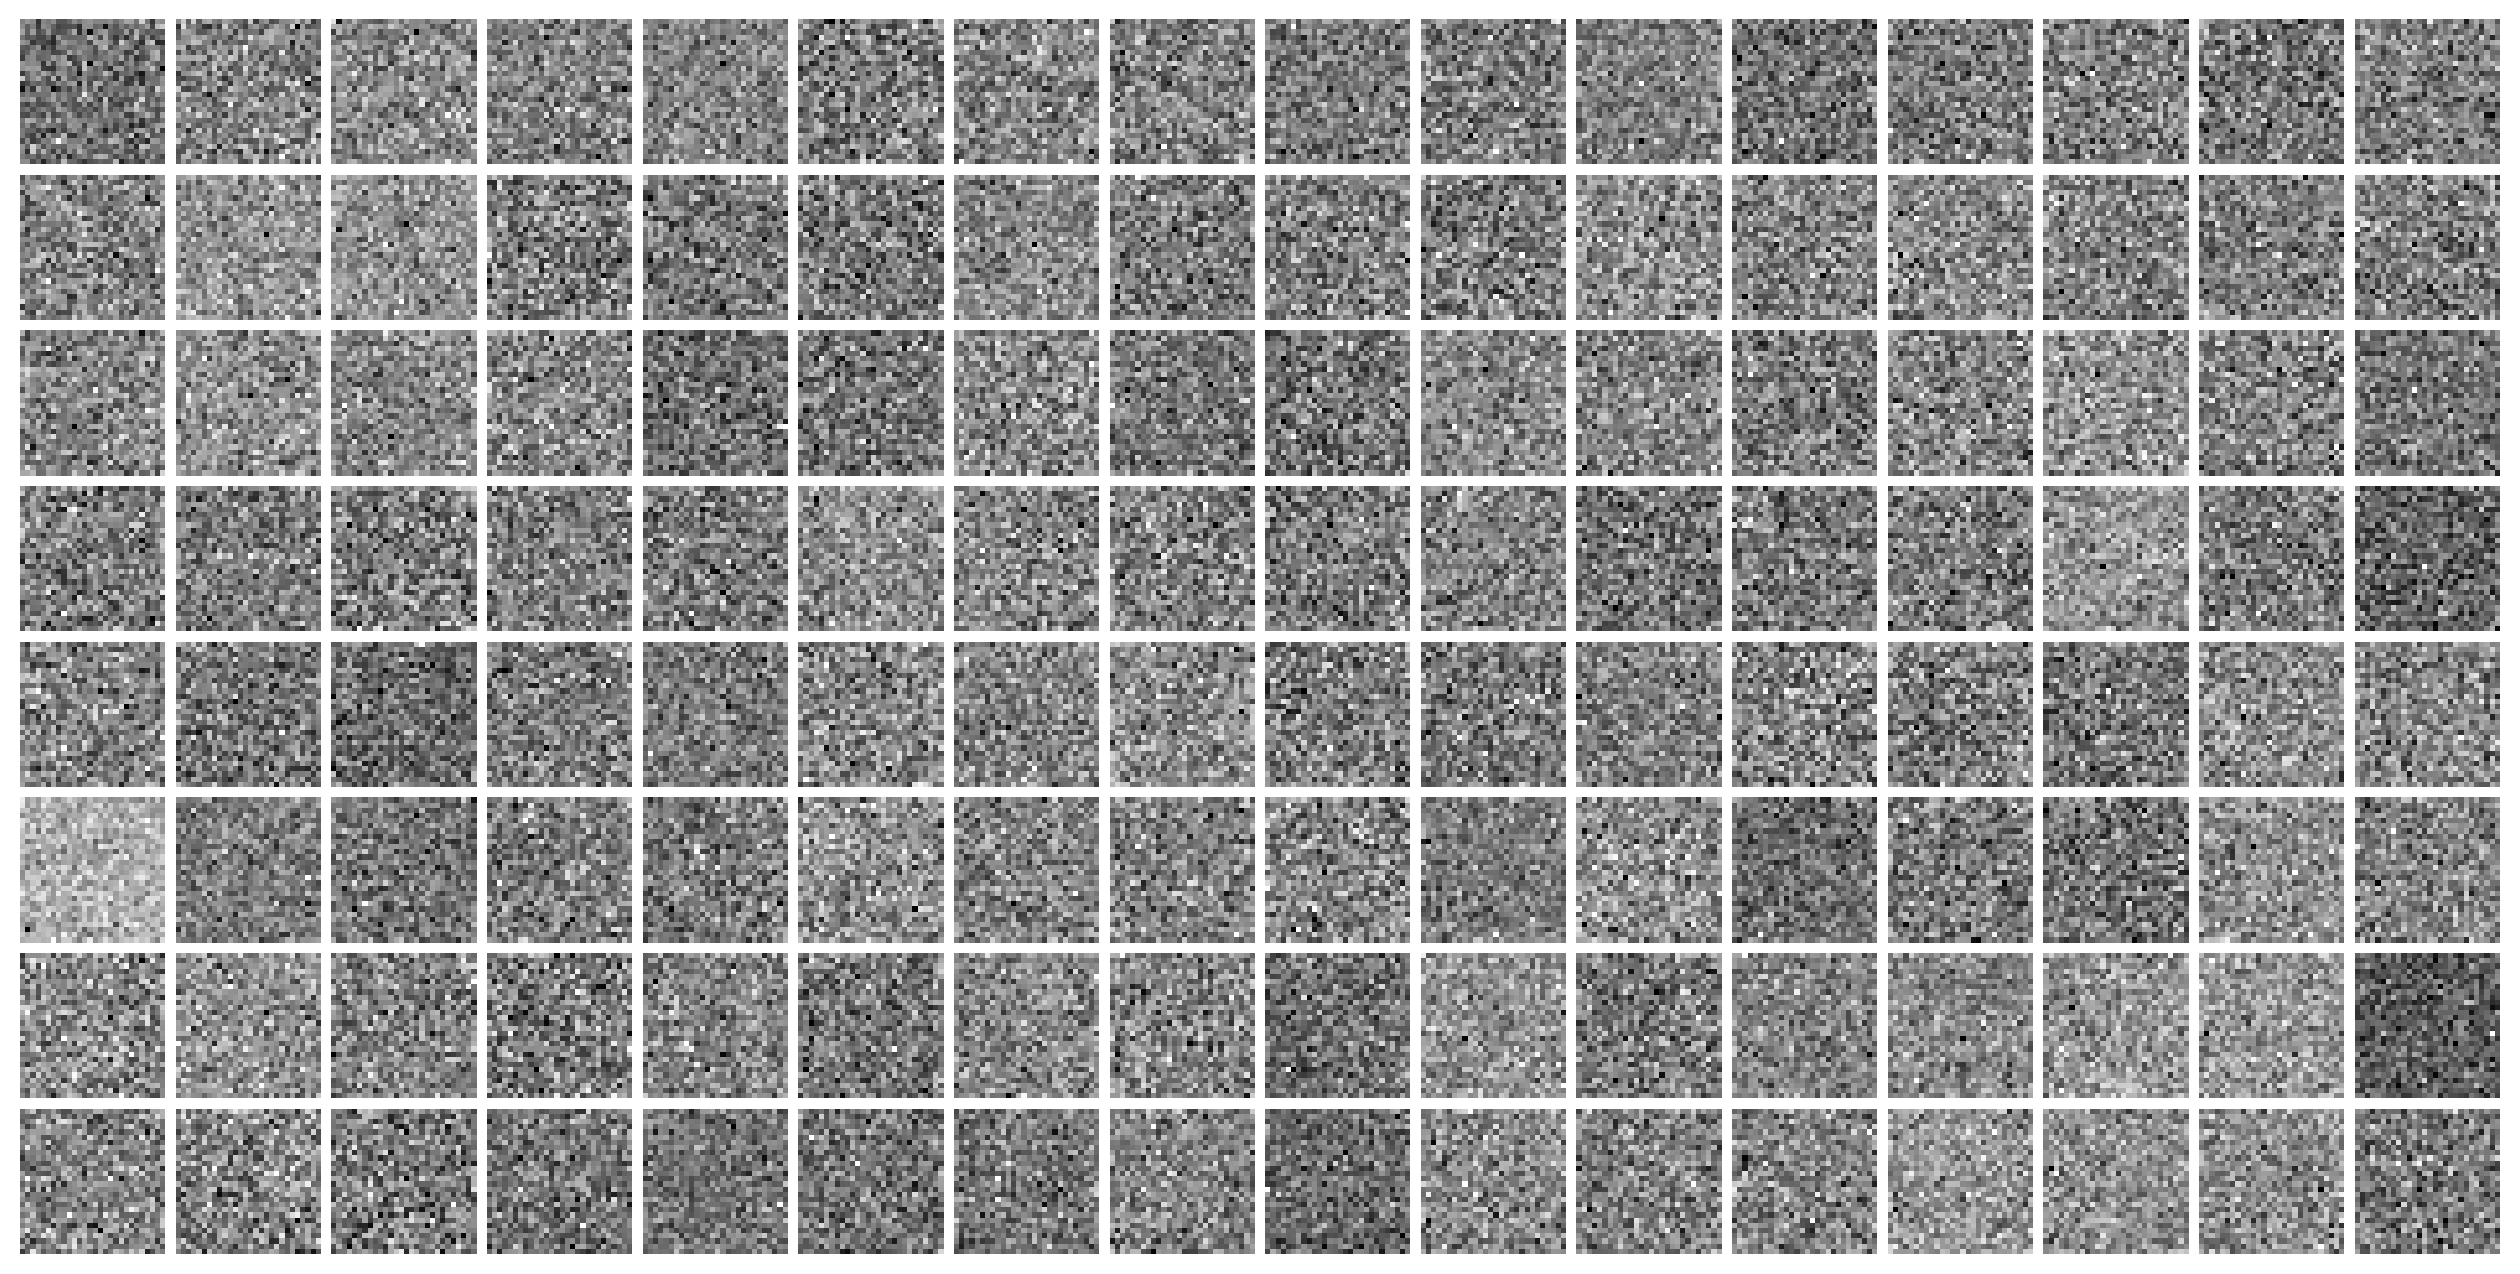

Epoch 0:	#####################################################	elapsed: 0.46s, reconstruction error: 26.83
Epoch 1:	#####################################################	elapsed: 0.33s, reconstruction error: 21.58
Epoch 2:	#####################################################	elapsed: 0.37s, reconstruction error: 19.08
Epoch 3:	#####################################################	elapsed: 0.37s, reconstruction error: 17.64
Epoch 4:	#####################################################	elapsed: 0.36s, reconstruction error: 16.36
Epoch 5:	#####################################################	elapsed: 0.35s, reconstruction error: 15.39
Epoch 6:	#####################################################	elapsed: 0.34s, reconstruction error: 14.59
Epoch 7:	#####################################################	elapsed: 0.35s, reconstruction error: 13.64
Epoch 8:	#####################################################	elapsed: 0.35s, reconstruction error: 13.27
Epoch 9:	############################

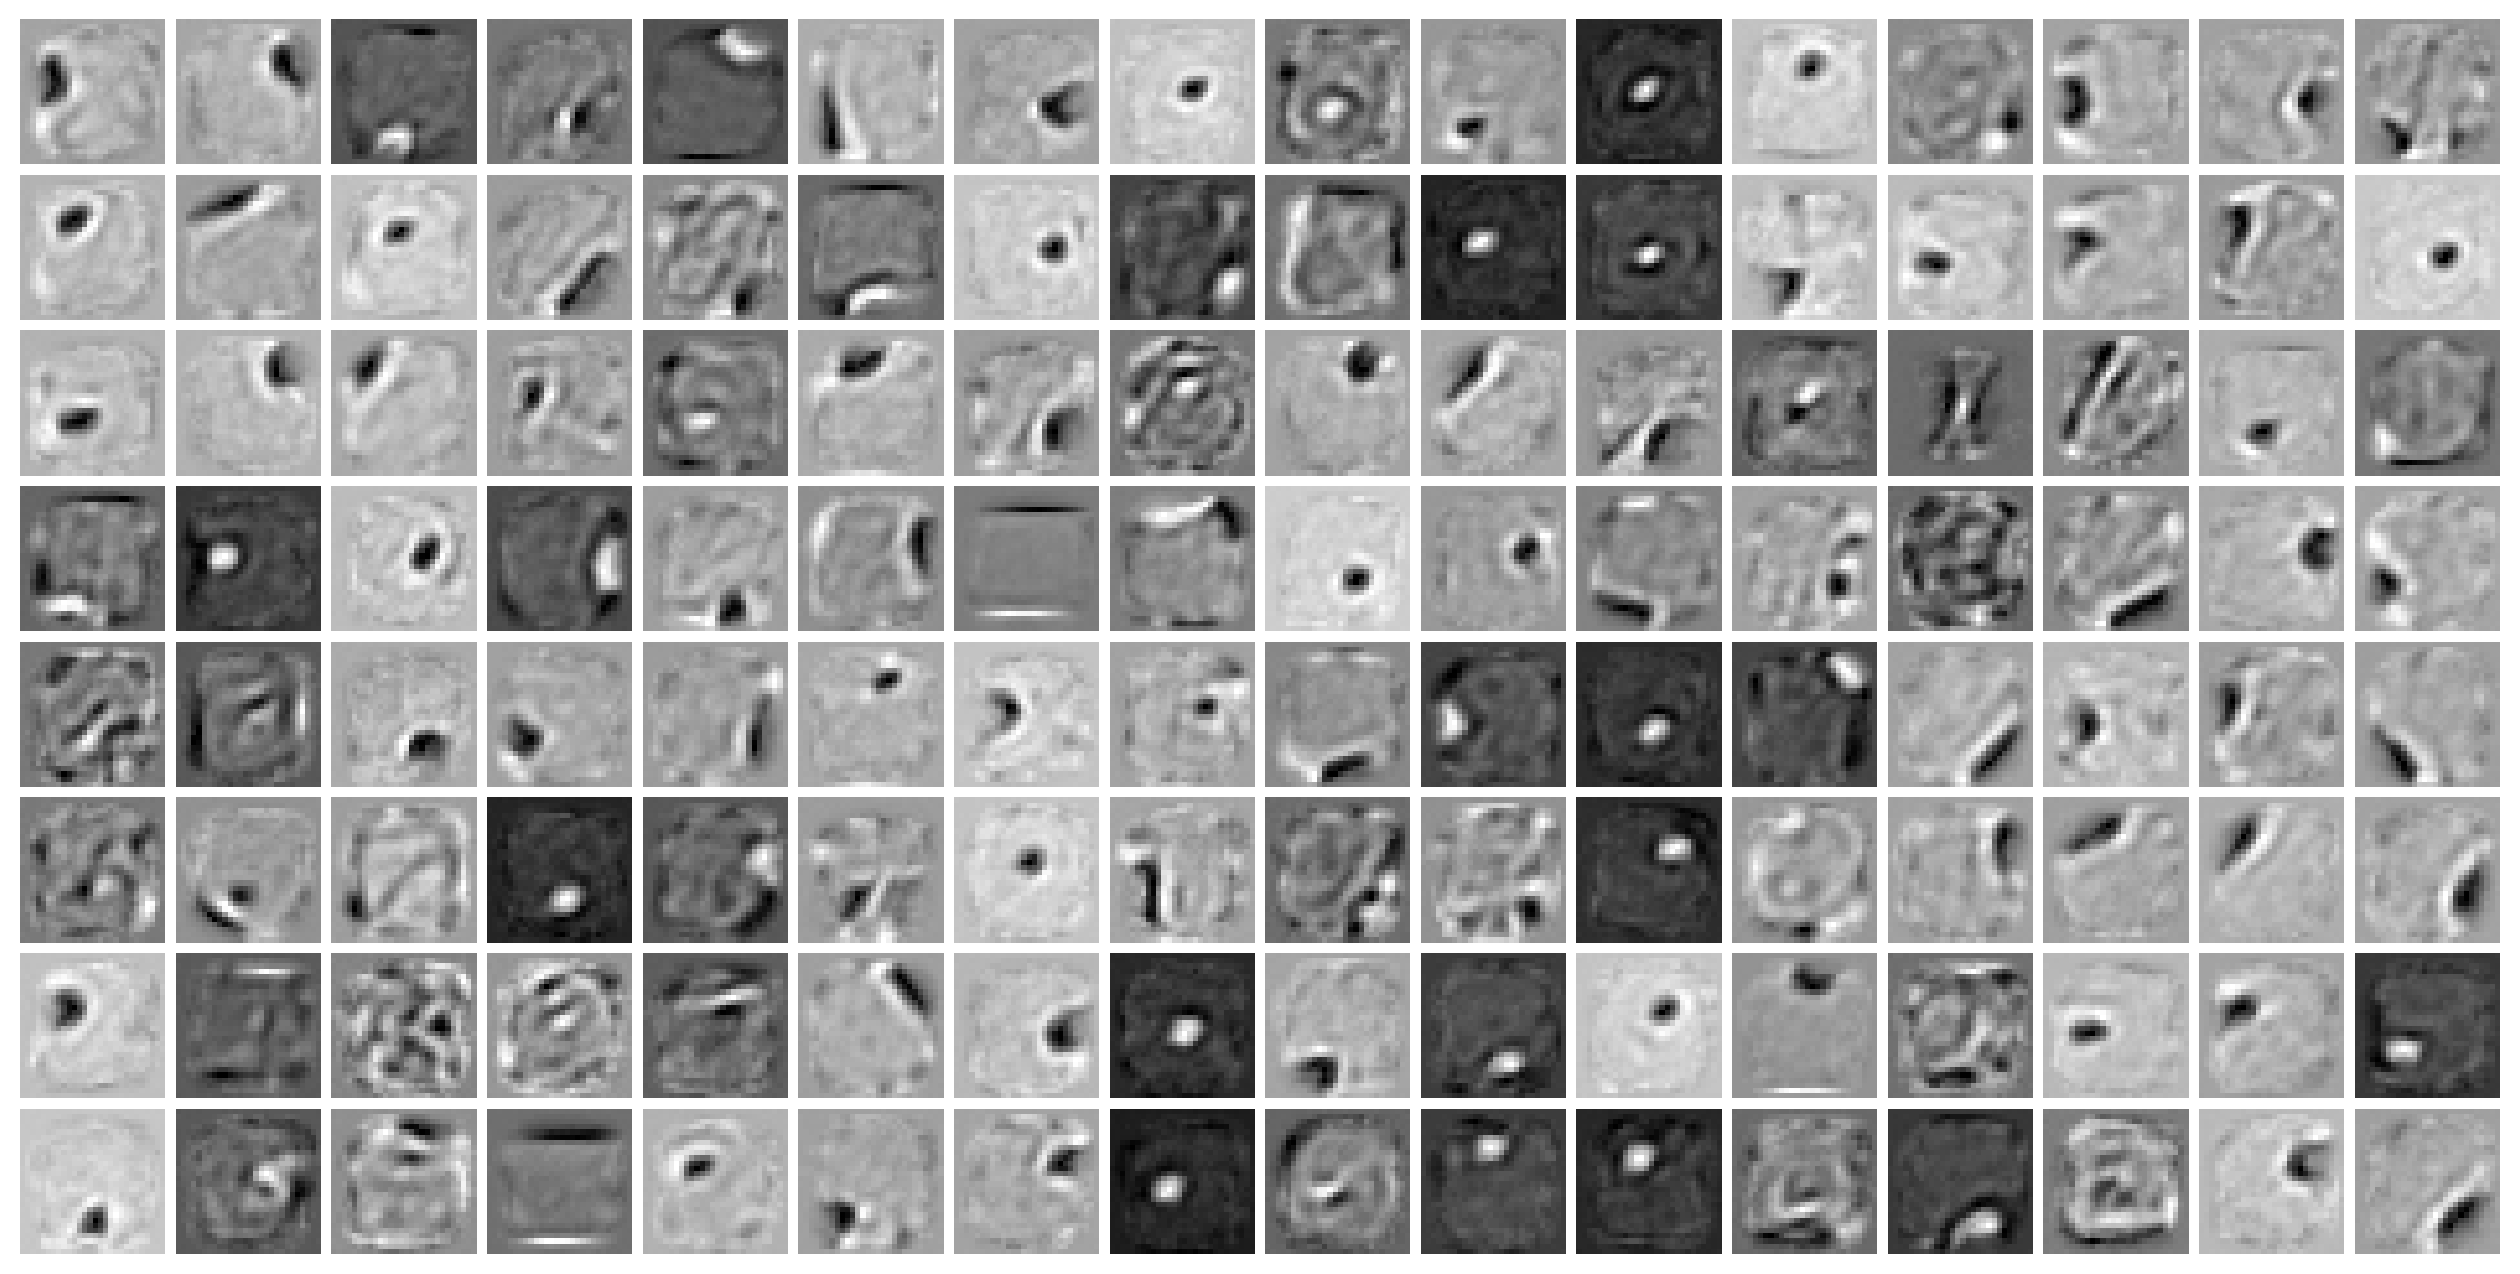

In [26]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

rbm = Rbm(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM)
draw_filters(rbm)

run_training(rbm, dataset, monitoring_set, BATCH_SIZE, EPOCHS_COUNT)

draw_filters(rbm)

# 2. DBN Training

In [27]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
    return visible

def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(sigmoid(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

### DBN reconstruction error

In [51]:
def dbn_reconstuction_error(dbn, layers_count, minibatch):
    # propagate up layers_count razy
    # liczymy reconstruction error tam gdzie sie znajdziemy
    visible = propagate_up(dbn, layers_count, minibatch)
    error = reconstuction_error(dbn[layers_count], visible)
    return error

### Sampling in Deep Belief Networks

In [52]:
def sample_rbm(rbm, minibatch, steps):
    observations_count = minibatch.shape[0]

    visible = minibatch
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    for cd_i in range(steps):
        hidden[:, :-1] = sigmoid(visible @ rbm.W[:, :-1])
        hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size)).astype(np.float32)
    
        visible[:, :-1] = sigmoid(hidden @ np.transpose(rbm.W[:-1, :]))
        if cd_i < (steps - 1):
            visible[:, :-1] = (visible[:, :-1] > rand(observations_count, rbm.visible_size)).astype(np.float32)

    return visible

In [64]:
def sample_dbn(dbn, layer_idx, minibatch, steps):
    # 1. propagate_up
    # 2. sample_rbm
    # 3. propagate_down
    visible = propagate_up(dbn, layer_idx, minibatch)
    sample = sample_rbm(dbn[layer_idx], visible, steps)
    hidden = propagate_down(dbn, layer_idx, sample)

    return hidden

In [65]:
def draw_layer_samples(dbn, layer_idx, minibatch, steps=200):
    samples = sample_dbn(dbn, layer_idx, minibatch, steps)
    tiles(np.reshape(samples[:, :-1], newshape=(-1, 16, 28, 28)))

### Greedy layer-wise training

In [62]:
def train_dbn(dbn, layer_idx, dataset, batch_size):
    # propagate_up
    dataset = propagate_up(dbn, layer_idx, dataset)
    
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 50) == 0: print("#", end="")

In [56]:
BATCH_SIZE = 128
EPOCHS_COUNT = 50

LEARNING_RATE = 0.1
MOMENTUM = 0.5

DBN_HIDDEN_LAYER_SIZE = 200
dbn = [
    Rbm(VISIBLE_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Rbm(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM),
    Rbm(DBN_HIDDEN_LAYER_SIZE, DBN_HIDDEN_LAYER_SIZE, LEARNING_RATE, MOMENTUM)
]

for layer_idx in range(len(dbn)):
    print("\nLearning layer {}".format(layer_idx))

    for epoch in range(EPOCHS_COUNT):
        print("Epoch {}:".format(epoch),  end="\t")

        if epoch == 5:
            dbn[layer_idx].momentum = 0.8
        
        start_time = time.time()
        train_dbn(dbn, layer_idx, dataset, BATCH_SIZE)
        elapsed = time.time() - start_time
        
        error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
        print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))
    
print("Training finished!")


Learning layer 0
Epoch 0:	#####################################################	elapsed: 0.52s, reconstruction error: 24.78
Epoch 1:	#####################################################	elapsed: 0.43s, reconstruction error: 19.33
Epoch 2:	#####################################################	elapsed: 0.41s, reconstruction error: 16.81
Epoch 3:	#####################################################	elapsed: 0.42s, reconstruction error: 15.42
Epoch 4:	#####################################################	elapsed: 0.49s, reconstruction error: 14.27
Epoch 5:	#####################################################	elapsed: 0.64s, reconstruction error: 13.28
Epoch 6:	#####################################################	elapsed: 0.42s, reconstruction error: 12.03
Epoch 7:	#####################################################	elapsed: 0.41s, reconstruction error: 11.63
Epoch 8:	#####################################################	elapsed: 0.41s, reconstruction error: 11.14
Epoch 9:	##########

/tmp/ipykernel_4472/3281778931.py:3: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  tiles(np.reshape(samples[:, :-1], newshape=(-1, 16, 28, 28)))


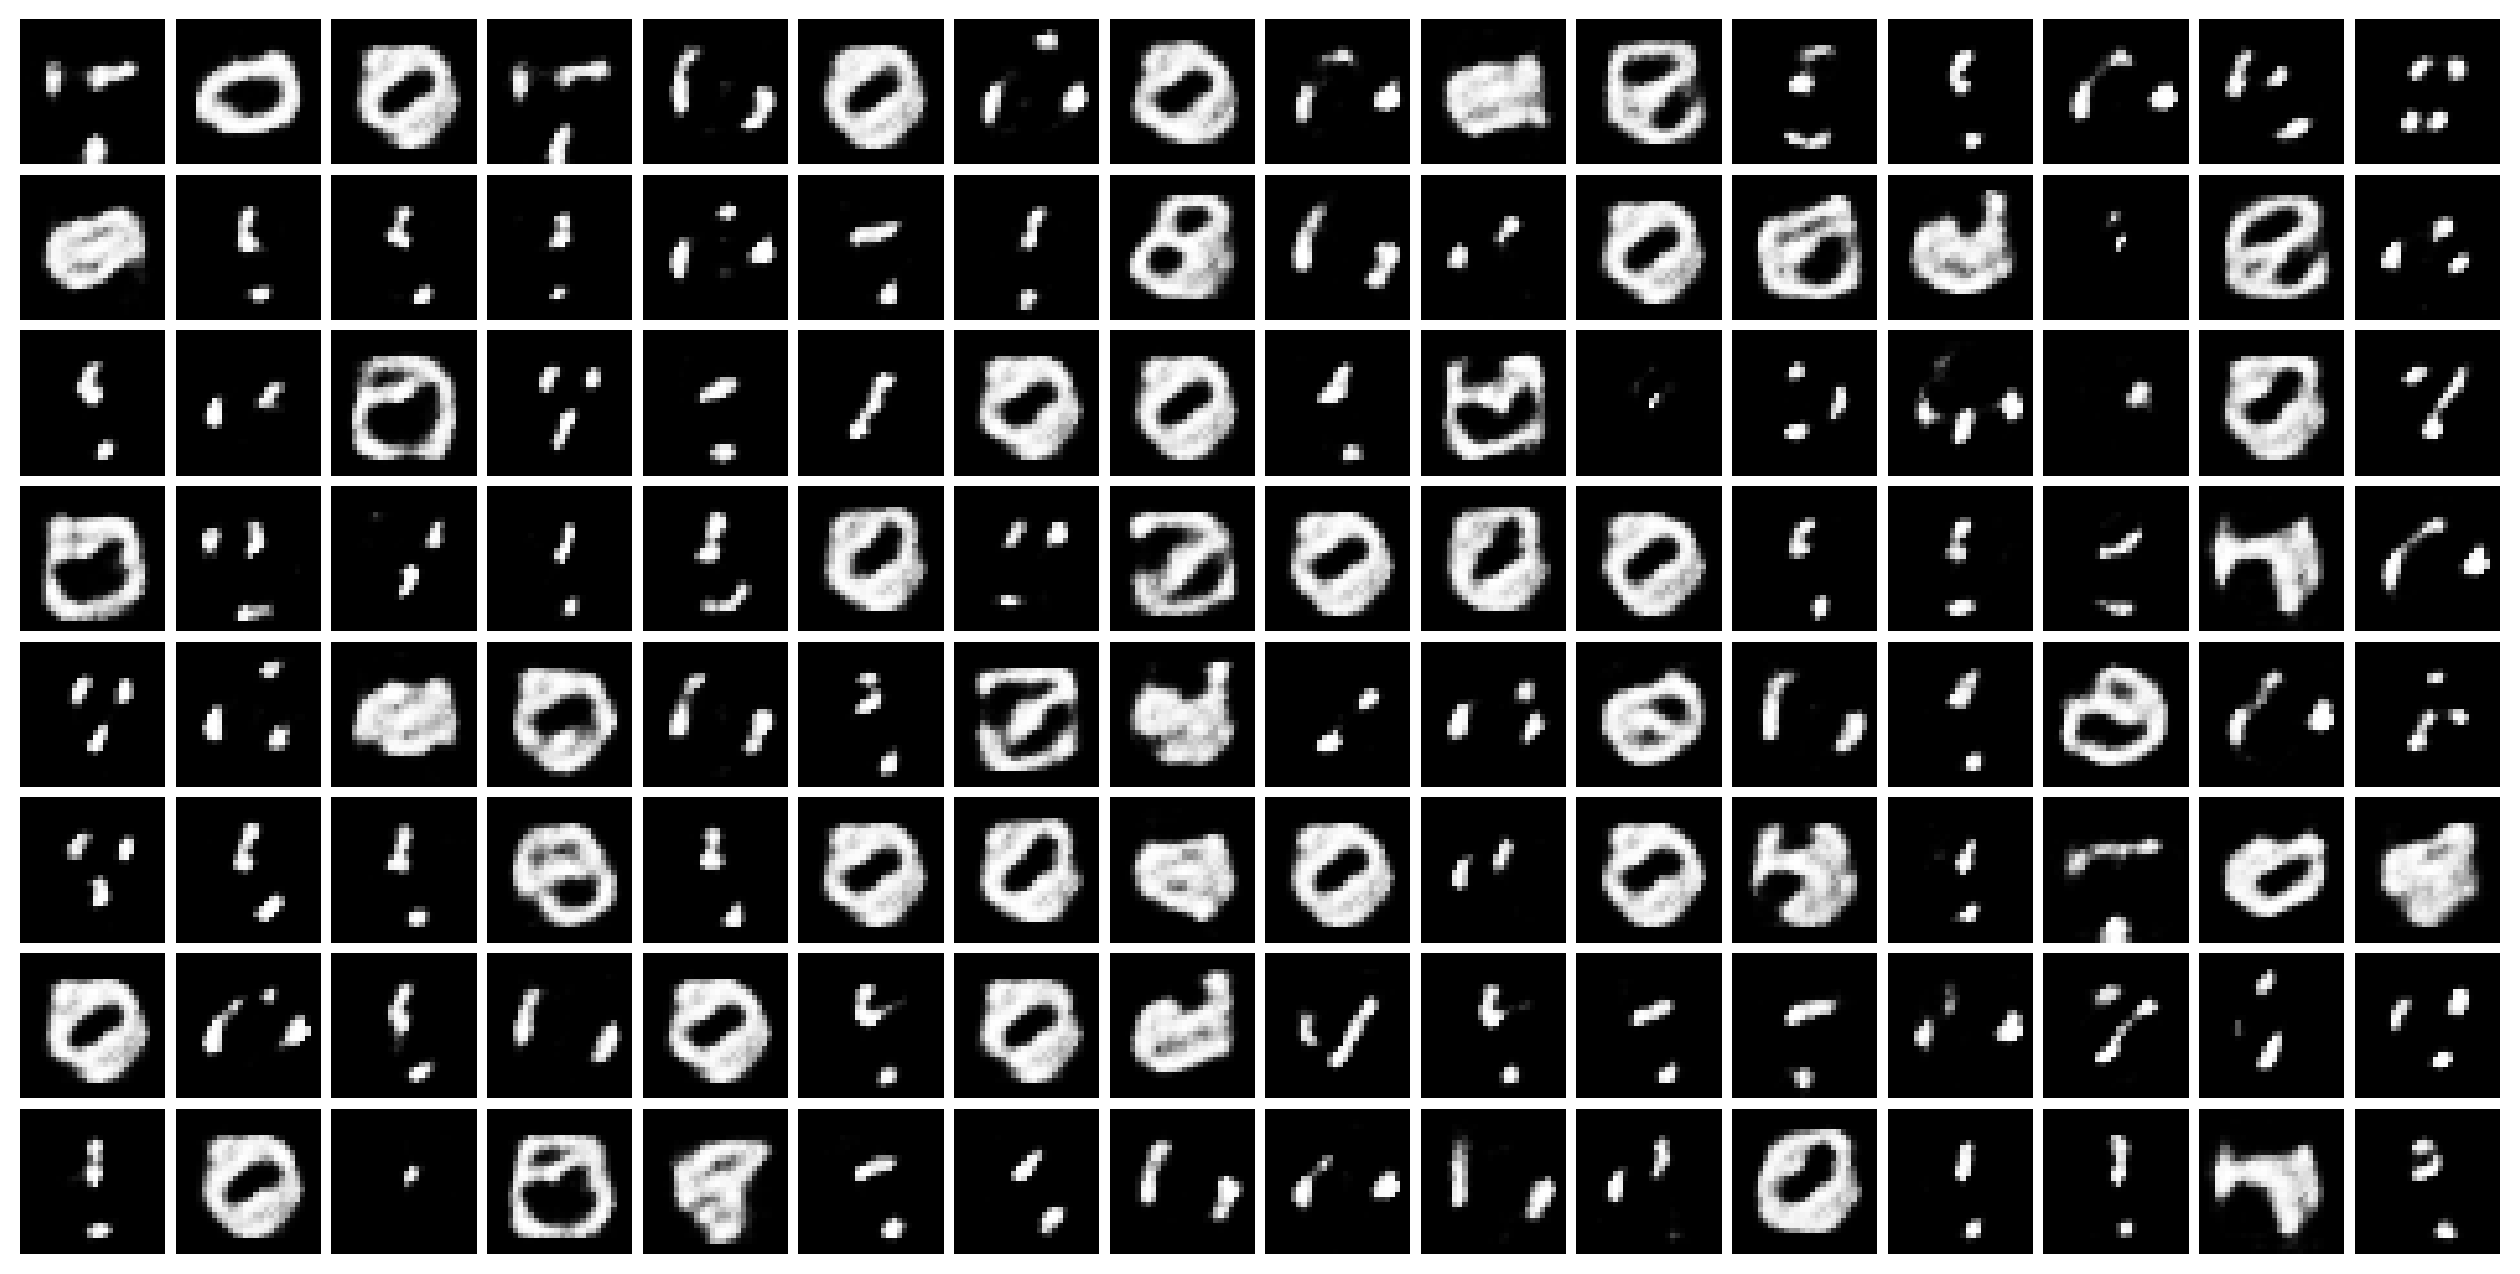

In [66]:
draw_layer_samples(dbn, 0, monitoring_set[:8*16])

/tmp/ipykernel_4472/3281778931.py:3: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  tiles(np.reshape(samples[:, :-1], newshape=(-1, 16, 28, 28)))


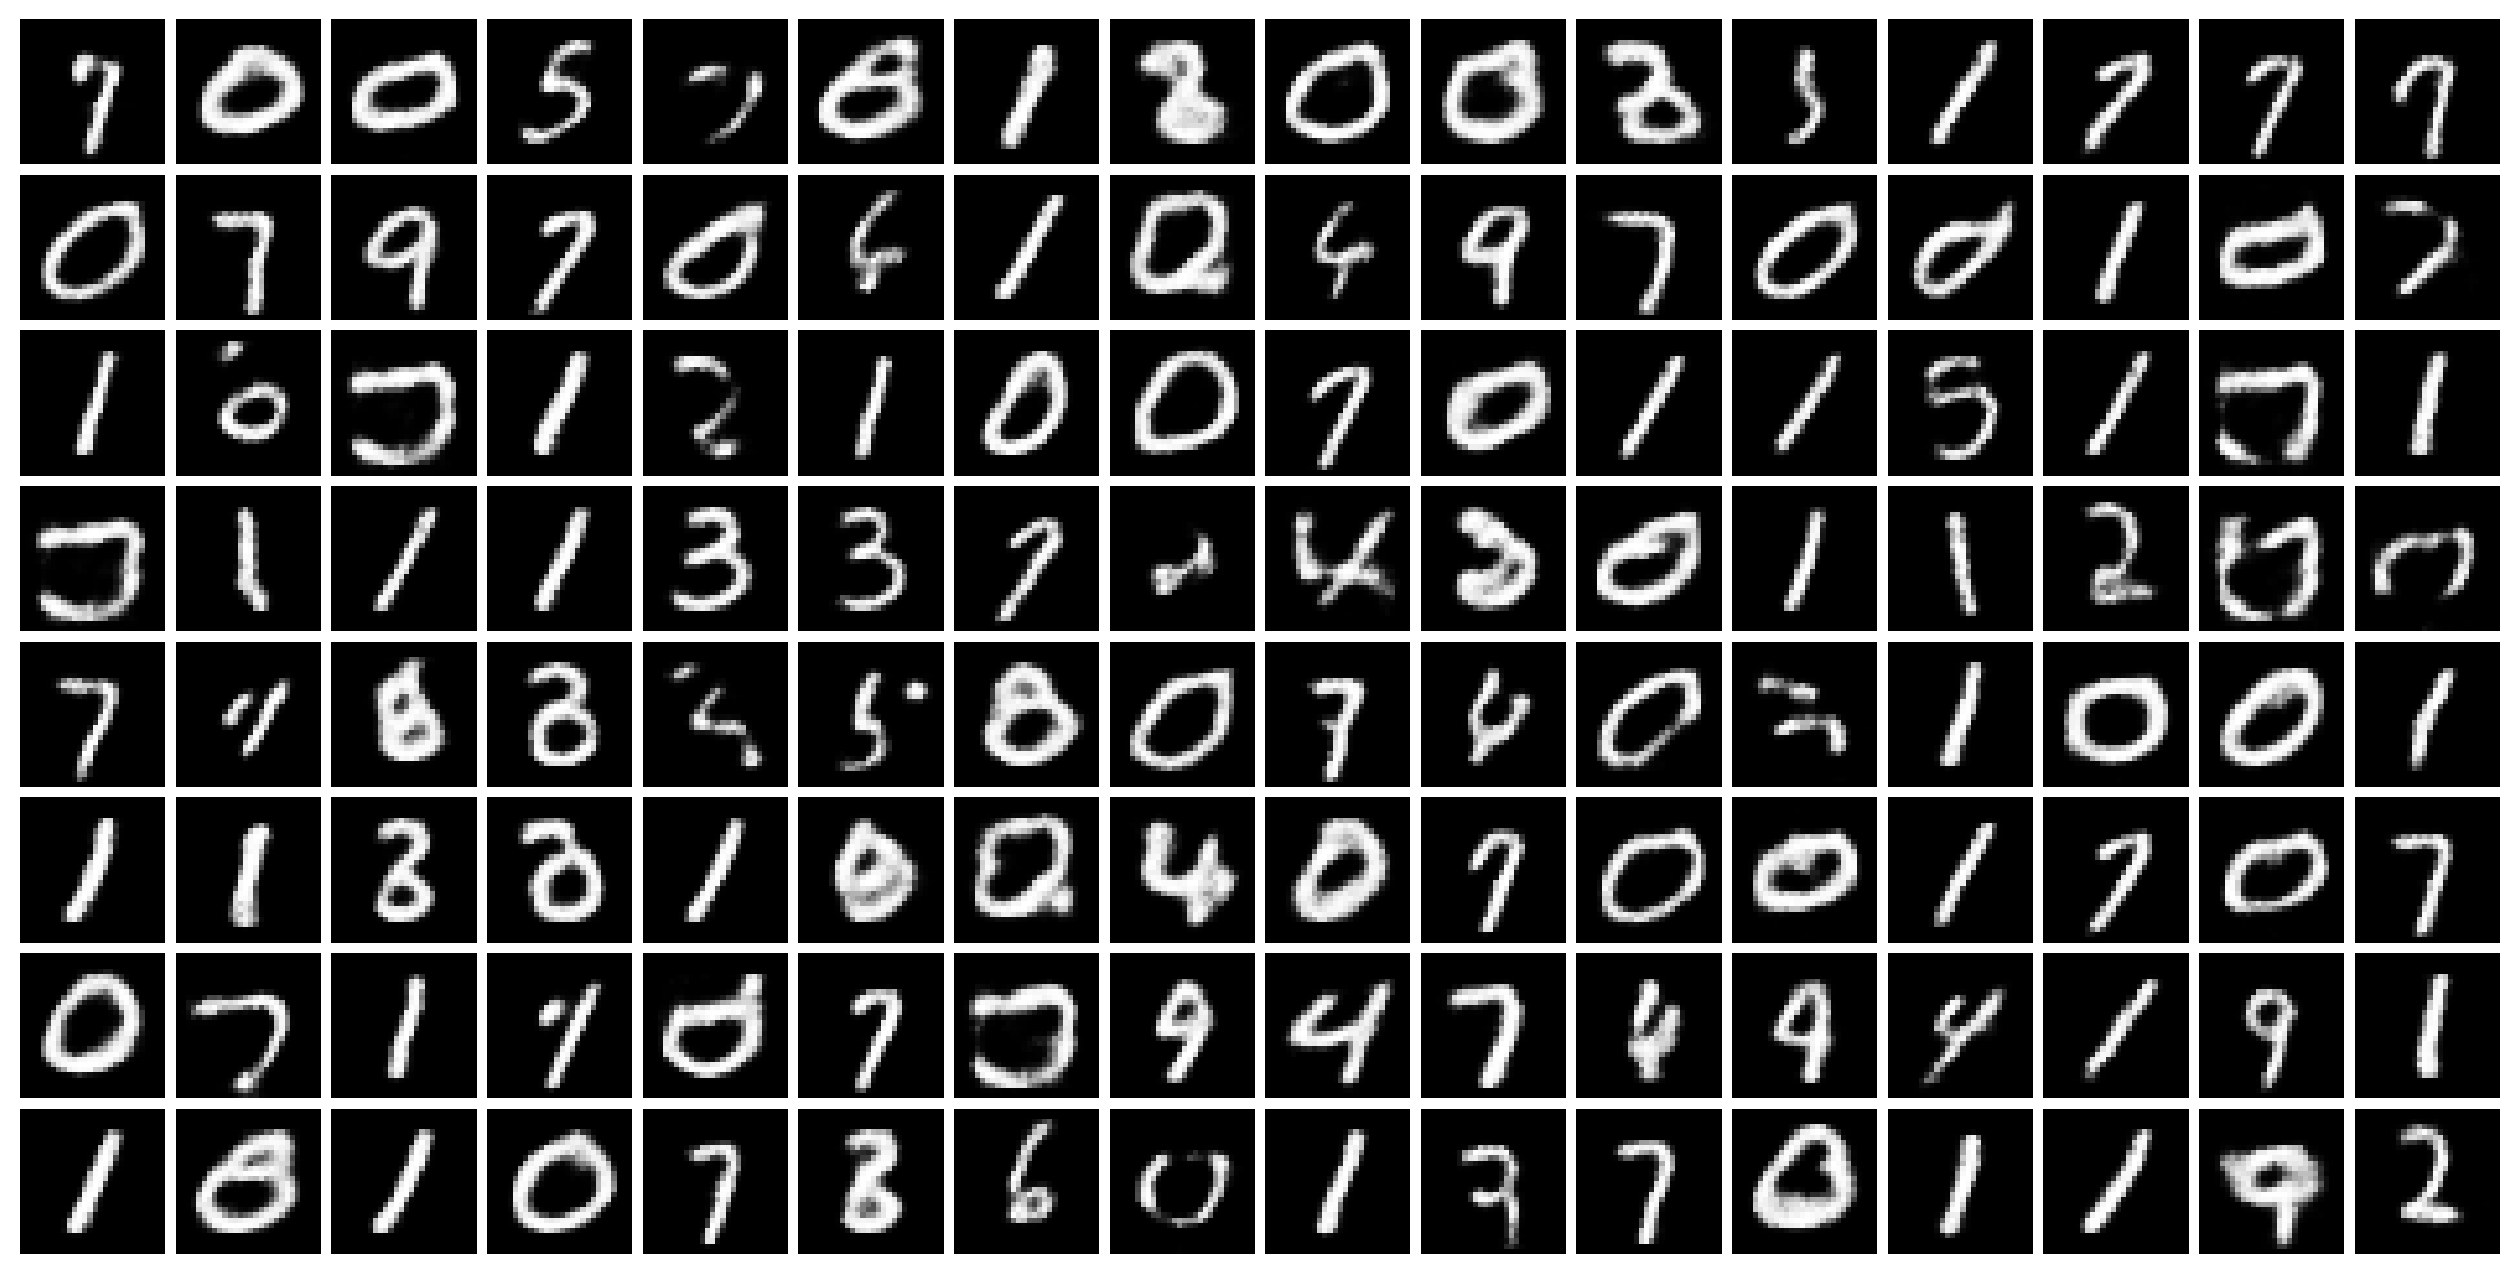

In [67]:
draw_layer_samples(dbn, 1, monitoring_set[:8*16])

/tmp/ipykernel_4472/3281778931.py:3: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  tiles(np.reshape(samples[:, :-1], newshape=(-1, 16, 28, 28)))


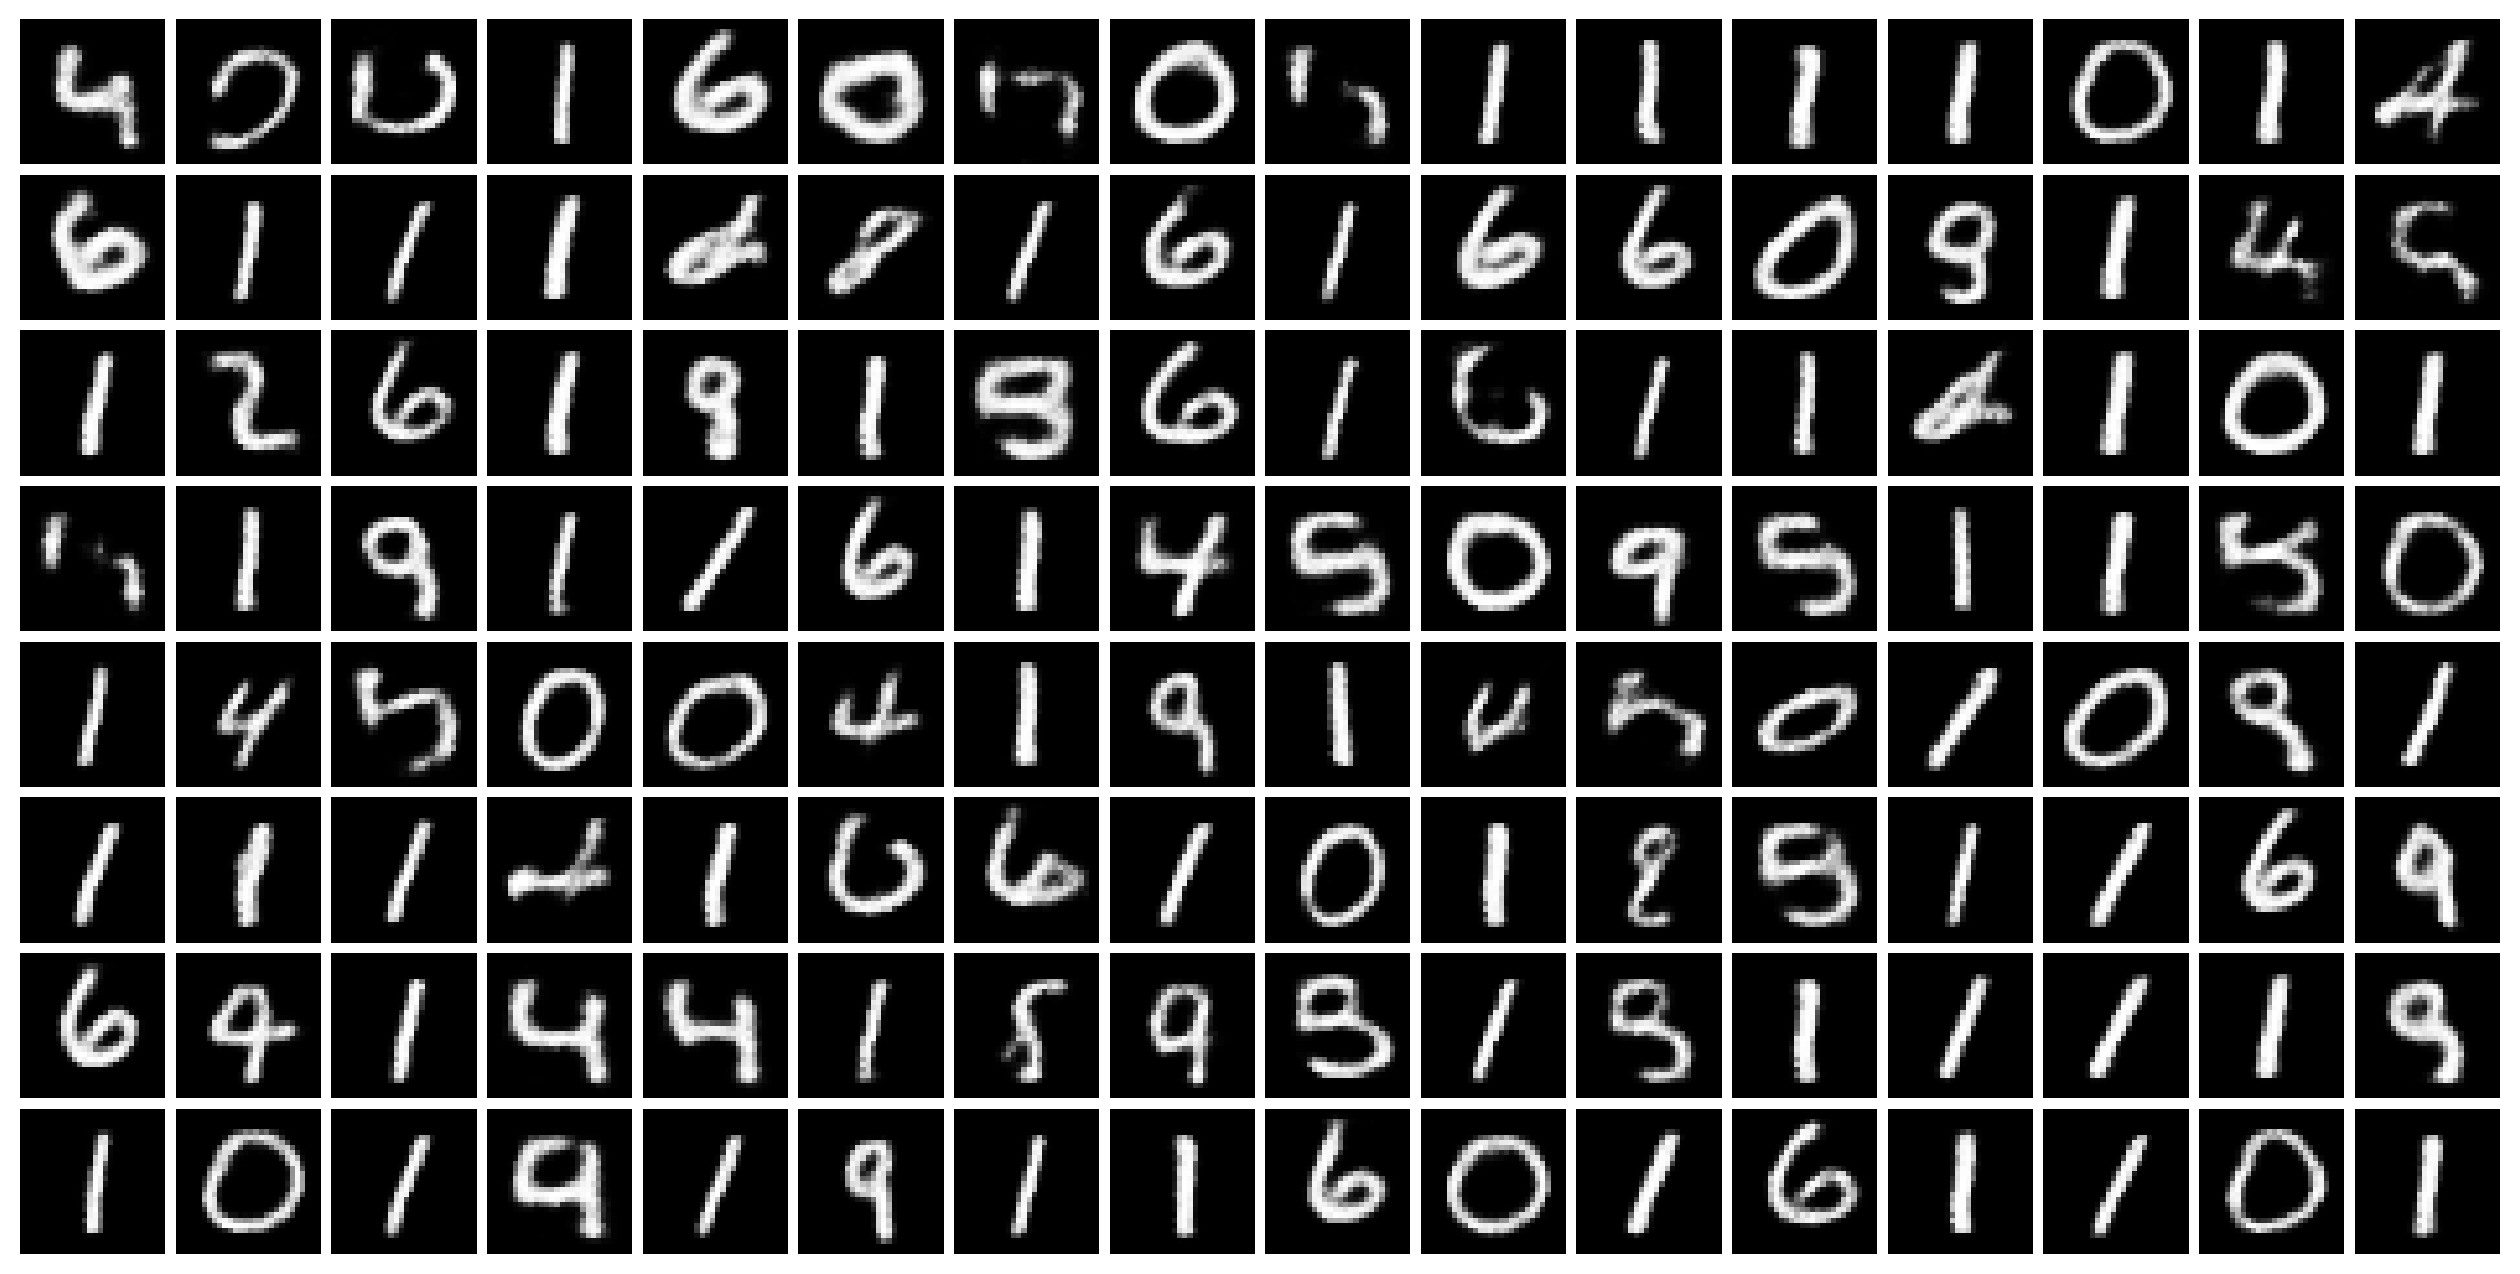

In [68]:
draw_layer_samples(dbn, 2, monitoring_set[:8*16])